# Experiment: Baseline U-Net Test Set Evaluation

**Date:** 2026-01-19  
**Experiment ID:** `baseline_unet_run1_test_eval`  
**Status:** Complete  

---

## 1. Overview

### 1.1 Objective
Evaluate the trained baseline U-Net model on held-out test cases to assess:
- Dose prediction accuracy (MAE)
- Spatial accuracy (Gamma pass rate 3%/3mm)
- Clinical constraint compliance (DVH metrics)

### 1.2 Key Results

| Metric | Value | Target | Status |
|--------|-------|--------|--------|
| **MAE** | **1.43 ± 0.24 Gy** | < 3 Gy | PASS |
| **Gamma (3%/3mm)** | **14.2 ± 5.7%** | > 95% | FAIL |
| PTV70 D95 Error | -10 to -14 Gy | - | Underdosed |
| PTV56 D95 Error | -22 Gy | - | Severely Underdosed |
| OAR Constraints | All Pass | - | Conservative |

### 1.3 Conclusion
The baseline U-Net achieves excellent overall dose accuracy (MAE) but poor spatial accuracy (gamma). The model systematically underdoses target volumes (PTVs) while being conservative on organs at risk (OARs). This "blurred" dose pattern motivates the DDPM approach for capturing fine spatial details.

---

## 2. Reproducibility Information

In [1]:
import subprocess
import torch
from datetime import datetime

# Auto-capture reproducibility info
REPRODUCIBILITY_INFO = {
    'git_commit': subprocess.getoutput('git rev-parse HEAD'),
    'git_message': subprocess.getoutput('git log -1 --format="%s"'),
    'git_dirty': subprocess.getoutput('git status --porcelain') != '',
    'python_version': subprocess.getoutput('python --version').split()[1],
    'pytorch_version': torch.__version__,
    'cuda_version': torch.version.cuda if torch.cuda.is_available() else 'N/A',
    'gpu': torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'N/A',
    'random_seed': 42,
    'experiment_date': '2026-01-19',
}

print('Reproducibility Information:')
for k, v in REPRODUCIBILITY_INFO.items():
    print(f'  {k}: {v}')

if REPRODUCIBILITY_INFO['git_dirty']:
    print('\n  WARNING: Uncommitted changes present!')

Reproducibility Information:
  git_commit: 4e3ab8e35a032857798e81e4df7009b8655831d6
  git_message: Add Claude Code project instructions
  git_dirty: True
  python_version: 3.12.12
  pytorch_version: 2.4.1
  cuda_version: 12.4
  gpu: NVIDIA GeForce RTX 3090
  random_seed: 42
  experiment_date: 2026-01-19



### Command to Reproduce

```bash
# Checkout correct commit
git checkout <COMMIT_HASH>

# Run inference with evaluation
python scripts/inference_baseline_unet.py \
    --checkpoint runs/baseline_unet_run1/checkpoints/best-epoch=012-val/mae_gy=3.735.ckpt \
    --input_dir data/test_cases \
    --output_dir predictions/baseline_unet_test \
    --compute_metrics \
    --gamma_subsample 4 \
    --rx_dose_gy 70.0
```

---

## 3. Dataset

In [2]:
DATASET_INFO = {
    'total_cases': 23,
    'train_cases': 18,
    'val_cases': 3,
    'test_cases': 2,
    'test_case_ids': ['case_0007', 'case_0021'],
    'preprocessing_version': 'v2.2.0',
    'data_location': '/mnt/i/processed_npz/',
}

print('Dataset Information:')
for k, v in DATASET_INFO.items():
    print(f'  {k}: {v}')

Dataset Information:
  total_cases: 23
  train_cases: 18
  val_cases: 3
  test_cases: 2
  test_case_ids: ['case_0007', 'case_0021']
  preprocessing_version: v2.2.0
  data_location: /mnt/i/processed_npz/


---

## 4. Model Configuration

In [3]:
MODEL_CONFIG = {
    'architecture': 'BaselineUNet3D',
    'parameters': '23,732,801',
    'input_channels': 9,  # 1 CT + 8 structure SDFs
    'output_channels': 1,  # dose
    'base_features': 32,
    'conditioning': 'FiLM (Feature-wise Linear Modulation)',
    'constraint_dim': 8,
}

print('Model Configuration:')
for k, v in MODEL_CONFIG.items():
    print(f'  {k}: {v}')

Model Configuration:
  architecture: BaselineUNet3D
  parameters: 23,732,801
  input_channels: 9
  output_channels: 1
  base_features: 32
  conditioning: FiLM (Feature-wise Linear Modulation)
  constraint_dim: 8


---

## 5. Training Configuration (Reference)

In [4]:
import json

# Load training config from the run
with open('../runs/baseline_unet_run1/training_config.json', 'r') as f:
    TRAINING_CONFIG = json.load(f)

print('Training Configuration:')
for k, v in TRAINING_CONFIG.items():
    print(f'  {k}: {v}')

Training Configuration:
  script: train_baseline_unet.py
  version: 1.0.0
  model: BaselineUNet3D (Direct Regression)
  timestamp: 2026-01-18T21:38:17.062961
  hparams: {'in_channels': 9, 'out_channels': 1, 'base_channels': 48, 'constraint_dim': 13, 'learning_rate': 0.0001, 'weight_decay': 0.01, 'rx_dose_gy': 70.0}
  model_params: 23732801


---

## 6. Results

### 6.1 Load Evaluation Results

In [5]:
import json
import numpy as np
import pandas as pd

# Load results
with open('../predictions/baseline_unet_test/baseline_evaluation_results.json', 'r') as f:
    results = json.load(f)

print(f"Model: {results['model_type']}")
print(f"Cases evaluated: {results['n_cases']}")
print(f"Timestamp: {results['timestamp']}")
print(f"\nAggregate Metrics:")
for k, v in results['aggregate_metrics'].items():
    print(f"  {k}: {v:.4f}" if isinstance(v, float) else f"  {k}: {v}")

Model: baseline_unet
Cases evaluated: 2
Timestamp: 2026-01-19T07:11:18.675706

Aggregate Metrics:
  mae_gy_mean: 1.4308
  mae_gy_std: 0.2444
  gamma_pass_rate_mean: 14.2152
  gamma_pass_rate_std: 5.7031


### 6.2 Per-Case Dose Metrics

In [6]:
# Create summary table
dose_metrics_data = []
for case in results['per_case_results']:
    dm = case['dose_metrics']
    gamma = case.get('gamma', {})
    dose_metrics_data.append({
        'Case': case['case_id'],
        'MAE (Gy)': dm['mae_gy'],
        'RMSE (Gy)': dm['rmse_gy'],
        'Max Error (Gy)': dm['max_error_gy'],
        'Gamma Pass (%)': gamma.get('gamma_pass_rate', 'N/A'),
        'Gamma Mean': gamma.get('gamma_mean', 'N/A'),
    })

df_dose = pd.DataFrame(dose_metrics_data)
print("Per-Case Dose Metrics:")
print(df_dose.to_string(index=False))

Per-Case Dose Metrics:
     Case  MAE (Gy)  RMSE (Gy)  Max Error (Gy)  Gamma Pass (%)  Gamma Mean
case_0007  1.675256   3.124941       27.489489       19.918316    3.033681
case_0021  1.186377   2.855804       28.233614        8.512085    3.688064


### 6.3 DVH Metrics by Structure

In [7]:
# Aggregate DVH metrics across cases
structures = ['PTV70', 'PTV56', 'Prostate', 'Rectum', 'Bladder', 'Femur_L', 'Femur_R', 'Bowel']

dvh_summary = []
for struct in structures:
    mae_values = []
    d95_errors = []
    for case in results['per_case_results']:
        if struct in case['dvh_metrics'] and case['dvh_metrics'][struct]['exists']:
            dvh = case['dvh_metrics'][struct]
            mae_values.append(dvh['mae_gy'])
            if 'D95_error' in dvh:
                d95_errors.append(dvh['D95_error'])
    
    dvh_summary.append({
        'Structure': struct,
        'MAE (Gy)': f"{np.mean(mae_values):.2f} ± {np.std(mae_values):.2f}" if mae_values else 'N/A',
        'D95 Error (Gy)': f"{np.mean(d95_errors):.2f} ± {np.std(d95_errors):.2f}" if d95_errors else 'N/A',
    })

df_dvh = pd.DataFrame(dvh_summary)
print("DVH Metrics by Structure:")
print(df_dvh.to_string(index=False))

DVH Metrics by Structure:
Structure     MAE (Gy) D95 Error (Gy)
    PTV70  9.44 ± 2.97  -10.00 ± 3.66
    PTV56 13.31 ± 2.38  -22.08 ± 0.14
 Prostate  5.02 ± 2.06   -9.87 ± 4.44
   Rectum  7.12 ± 0.20   10.28 ± 0.52
  Bladder  8.83 ± 0.95    9.33 ± 2.48
  Femur_L  7.04 ± 2.40    5.08 ± 2.02
  Femur_R  6.08 ± 2.19    5.07 ± 3.28
    Bowel  6.21 ± 0.27    2.74 ± 0.55


### 6.4 Clinical Constraint Compliance

In [8]:
# Summarize clinical constraint compliance
constraint_summary = []
for case in results['per_case_results']:
    cc = case['clinical_constraints']
    constraint_summary.append({
        'Case': case['case_id'],
        'Overall Pass': cc['overall_pass'],
        'Total Constraints': cc['summary']['total_constraints'],
        'Passed': cc['summary']['passed'],
        'Failed': cc['summary']['failed'],
        'Violations': ', '.join([f"{v['structure']}:{v['constraint']}" for v in cc['violations']]),
    })

df_cc = pd.DataFrame(constraint_summary)
print("Clinical Constraint Compliance:")
print(df_cc.to_string(index=False))

Clinical Constraint Compliance:
     Case  Overall Pass  Total Constraints  Passed  Failed                   Violations
case_0007         False                 19      13       2 PTV70:D95_min, PTV56:D95_min
case_0021         False                 19      13       2 PTV70:D95_min, PTV56:D95_min


### 6.5 Visualizations

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Publication-quality plot settings
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 11,
    'figure.figsize': (10, 6),
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'axes.grid': True,
    'grid.alpha': 0.3,
})

# Create output directory for figures
fig_dir = Path('../predictions/baseline_unet_test/figures')
fig_dir.mkdir(exist_ok=True)

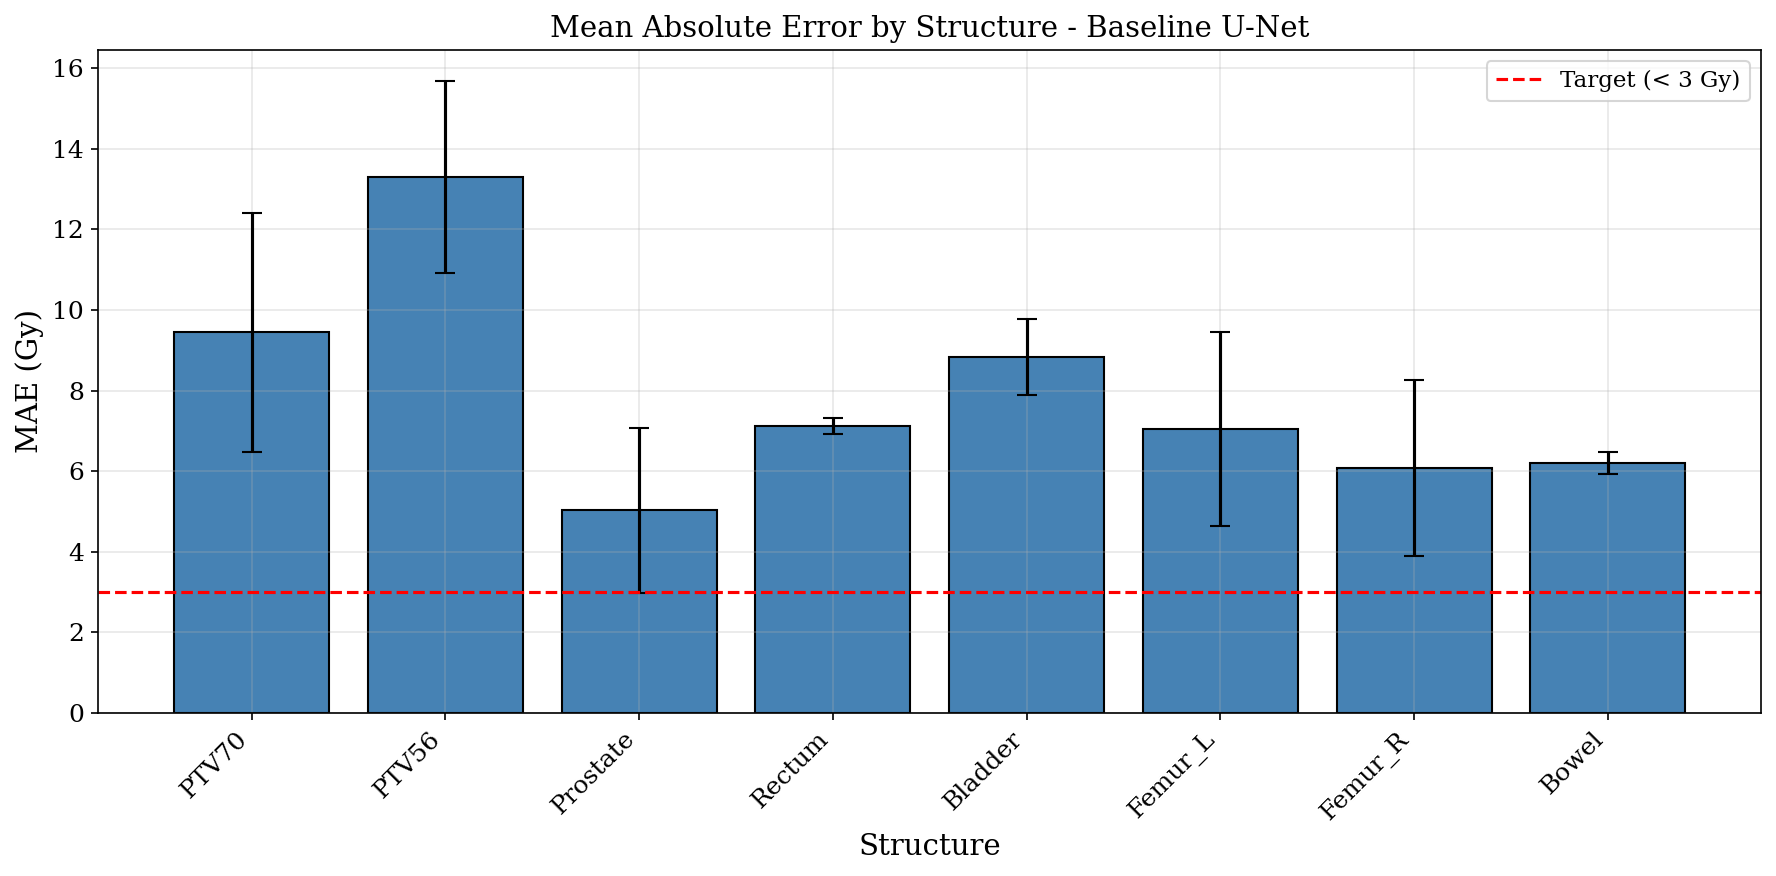

In [10]:
# Bar chart: MAE by structure
structures = ['PTV70', 'PTV56', 'Prostate', 'Rectum', 'Bladder', 'Femur_L', 'Femur_R', 'Bowel']
mae_means = []
mae_stds = []

for struct in structures:
    mae_values = []
    for case in results['per_case_results']:
        if struct in case['dvh_metrics'] and case['dvh_metrics'][struct]['exists']:
            mae_values.append(case['dvh_metrics'][struct]['mae_gy'])
    mae_means.append(np.mean(mae_values) if mae_values else 0)
    mae_stds.append(np.std(mae_values) if len(mae_values) > 1 else 0)

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(structures))
bars = ax.bar(x, mae_means, yerr=mae_stds, capsize=5, color='steelblue', edgecolor='black')
ax.axhline(y=3.0, color='red', linestyle='--', label='Target (< 3 Gy)')
ax.set_xlabel('Structure')
ax.set_ylabel('MAE (Gy)')
ax.set_title('Mean Absolute Error by Structure - Baseline U-Net')
ax.set_xticks(x)
ax.set_xticklabels(structures, rotation=45, ha='right')
ax.legend()
plt.tight_layout()
plt.savefig(fig_dir / 'mae_by_structure.png', dpi=300)
plt.savefig(fig_dir / 'mae_by_structure.pdf')
plt.show()

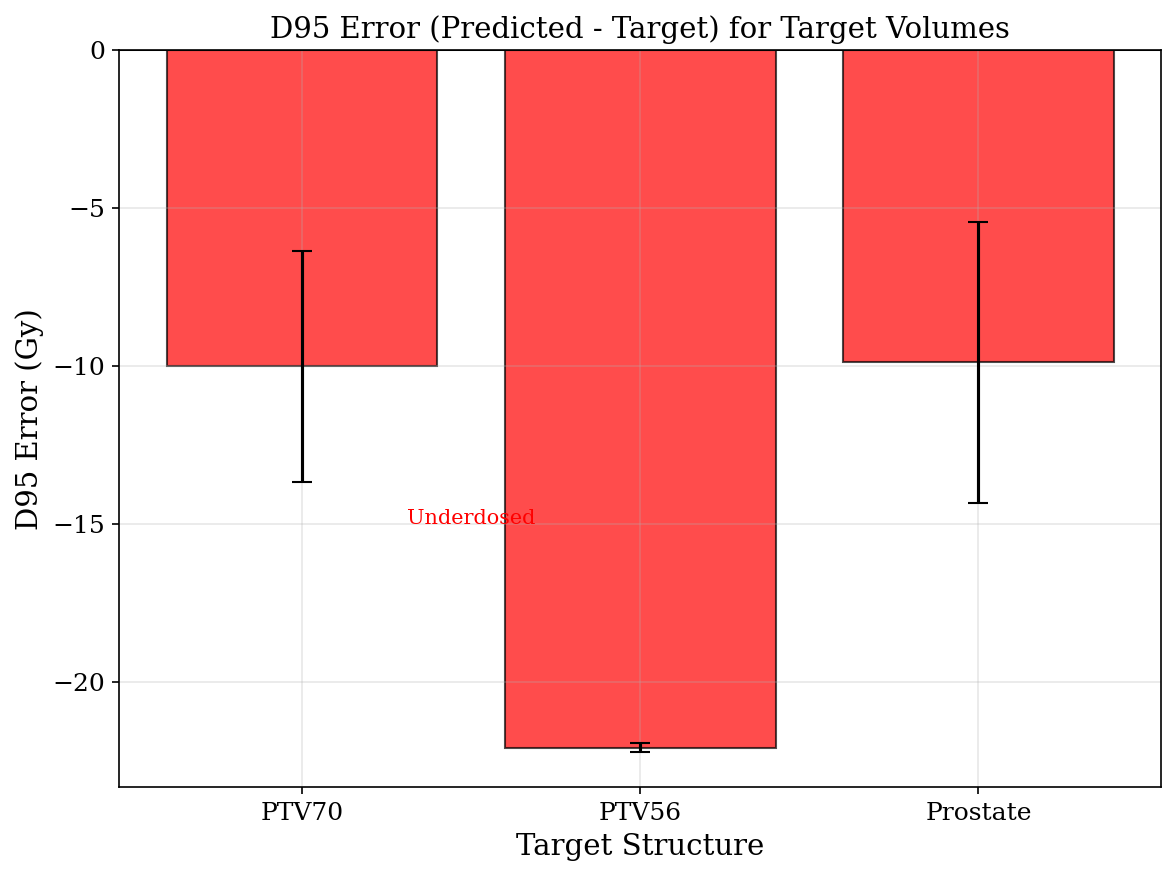

In [11]:
# D95 Error for targets
target_structs = ['PTV70', 'PTV56', 'Prostate']
d95_errors_by_struct = {s: [] for s in target_structs}

for case in results['per_case_results']:
    for struct in target_structs:
        if struct in case['dvh_metrics'] and 'D95_error' in case['dvh_metrics'][struct]:
            d95_errors_by_struct[struct].append(case['dvh_metrics'][struct]['D95_error'])

fig, ax = plt.subplots(figsize=(8, 6))
x = np.arange(len(target_structs))
means = [np.mean(d95_errors_by_struct[s]) for s in target_structs]
stds = [np.std(d95_errors_by_struct[s]) if len(d95_errors_by_struct[s]) > 1 else 0 for s in target_structs]

colors = ['red' if m < 0 else 'green' for m in means]
bars = ax.bar(x, means, yerr=stds, capsize=5, color=colors, edgecolor='black', alpha=0.7)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.set_xlabel('Target Structure')
ax.set_ylabel('D95 Error (Gy)')
ax.set_title('D95 Error (Predicted - Target) for Target Volumes')
ax.set_xticks(x)
ax.set_xticklabels(target_structs)

# Add annotation
ax.annotate('Underdosed', xy=(0.5, -15), fontsize=10, color='red', ha='center')

plt.tight_layout()
plt.savefig(fig_dir / 'd95_error_targets.png', dpi=300)
plt.savefig(fig_dir / 'd95_error_targets.pdf')
plt.show()

In [12]:
# Load and visualize dose distributions for one case
case_id = 'case_0021'
pred_path = f'../predictions/baseline_unet_test/{case_id}_pred.npz'
gt_path = f'/mnt/i/processed_npz/{case_id}.npz'

# Load data
pred_data = np.load(pred_path)
gt_data = np.load(gt_path)

pred_dose = pred_data['dose'] * 70.0  # Convert to Gy
gt_dose = gt_data['dose'] * 70.0
ct = gt_data['ct']

# Find slice with maximum dose
max_slice = np.argmax(np.sum(gt_dose, axis=(0, 1)))

print(f"Case: {case_id}")
print(f"Showing axial slice: {max_slice}")
print(f"Pred dose range: {pred_dose.min():.1f} - {pred_dose.max():.1f} Gy")
print(f"GT dose range: {gt_dose.min():.1f} - {gt_dose.max():.1f} Gy")

Case: case_0021
Showing axial slice: 135
Pred dose range: 0.0 - 80.8 Gy
GT dose range: 0.0 - 73.1 Gy


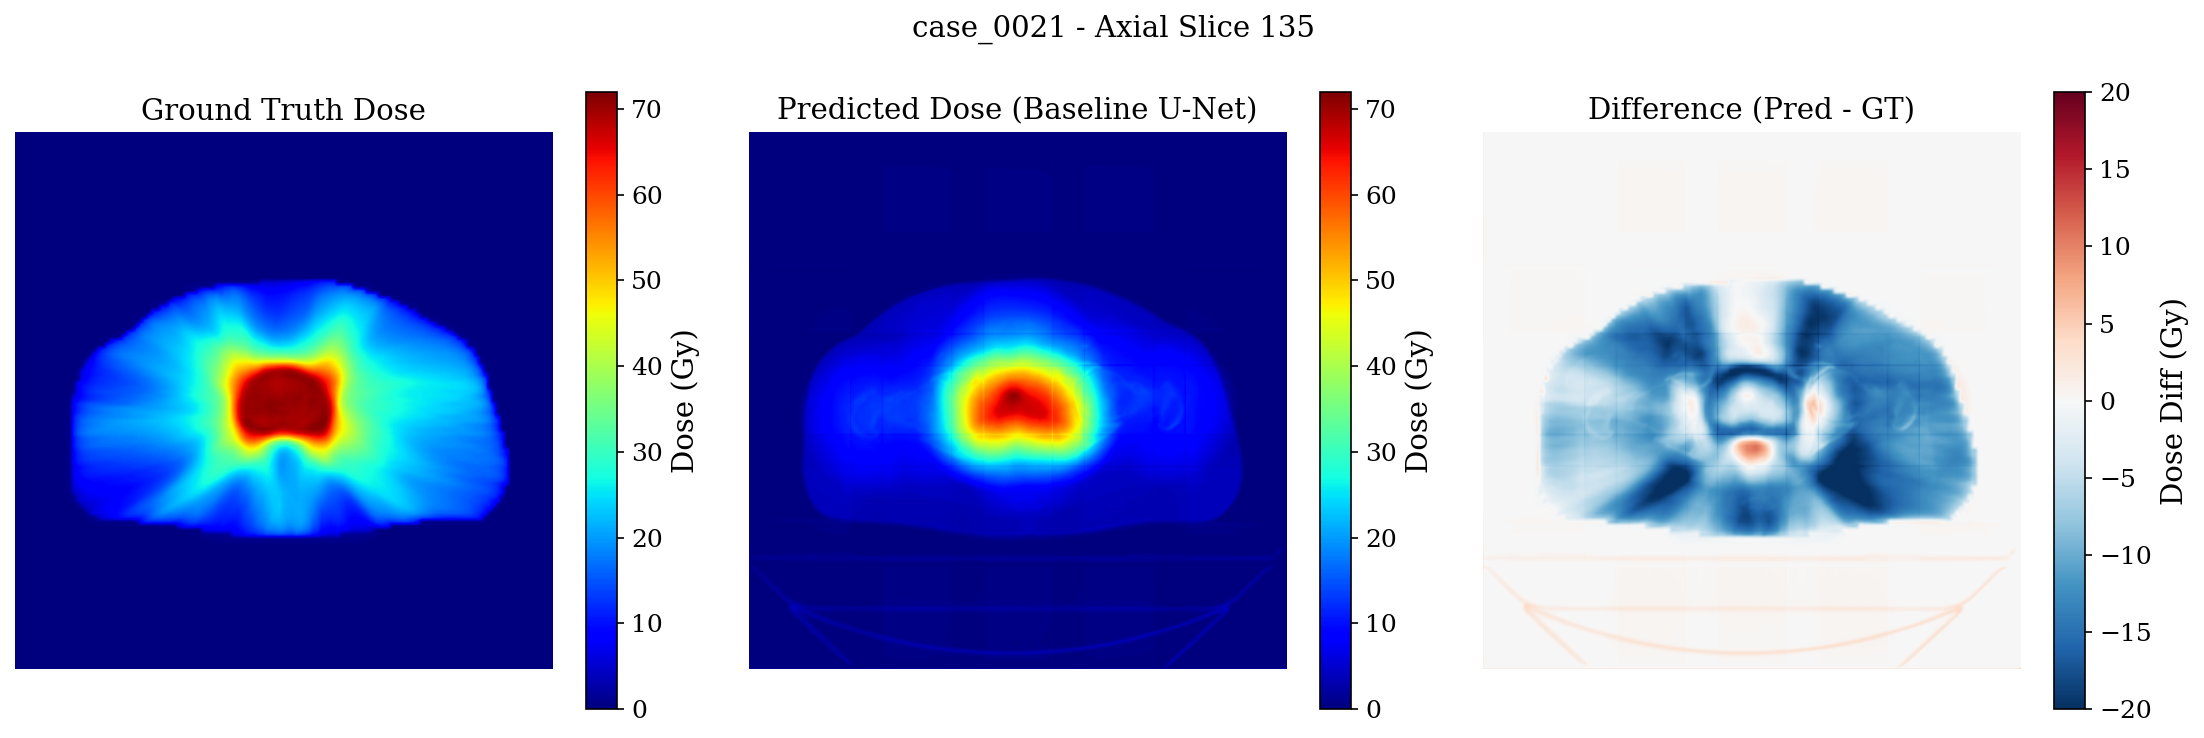

In [13]:
# Side-by-side dose comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

vmax = max(pred_dose[:, :, max_slice].max(), gt_dose[:, :, max_slice].max())

# Ground truth
im0 = axes[0].imshow(gt_dose[:, :, max_slice], cmap='jet', vmin=0, vmax=vmax)
axes[0].set_title('Ground Truth Dose')
axes[0].axis('off')
plt.colorbar(im0, ax=axes[0], label='Dose (Gy)')

# Predicted
im1 = axes[1].imshow(pred_dose[:, :, max_slice], cmap='jet', vmin=0, vmax=vmax)
axes[1].set_title('Predicted Dose (Baseline U-Net)')
axes[1].axis('off')
plt.colorbar(im1, ax=axes[1], label='Dose (Gy)')

# Difference
diff = pred_dose[:, :, max_slice] - gt_dose[:, :, max_slice]
im2 = axes[2].imshow(diff, cmap='RdBu_r', vmin=-20, vmax=20)
axes[2].set_title('Difference (Pred - GT)')
axes[2].axis('off')
plt.colorbar(im2, ax=axes[2], label='Dose Diff (Gy)')

plt.suptitle(f'{case_id} - Axial Slice {max_slice}', fontsize=14)
plt.tight_layout()
plt.savefig(fig_dir / f'{case_id}_dose_comparison.png', dpi=300)
plt.savefig(fig_dir / f'{case_id}_dose_comparison.pdf')
plt.show()

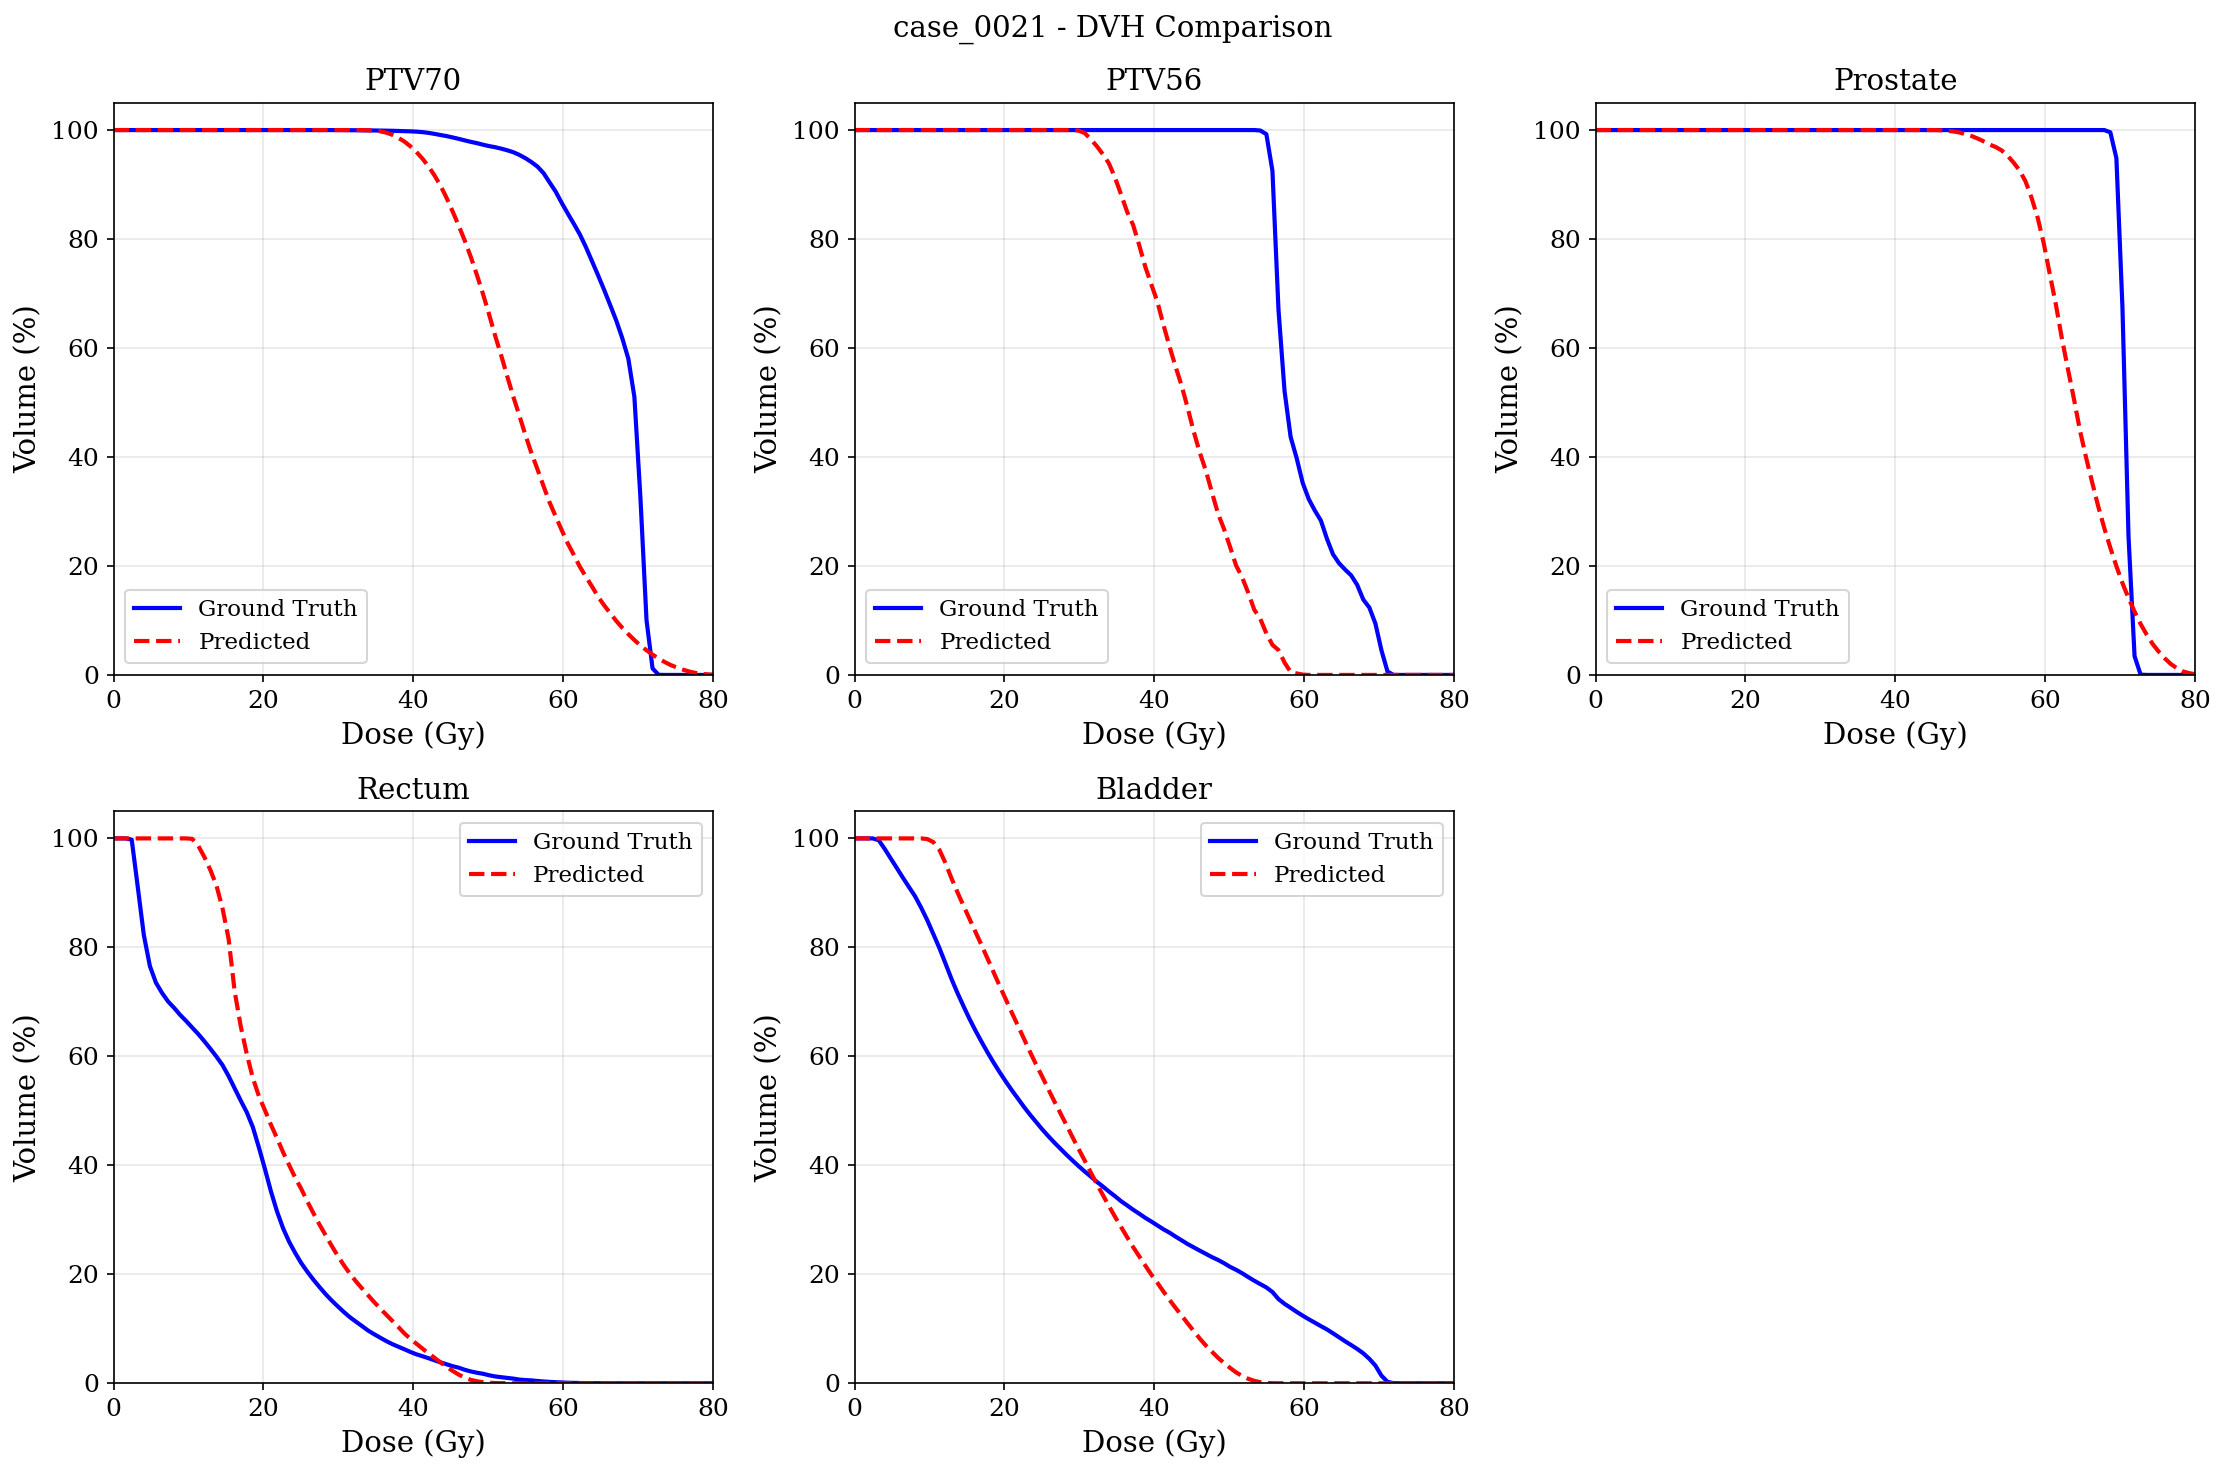

In [14]:
# DVH comparison for key structures
masks = gt_data['masks']
structure_names = {0: 'PTV70', 1: 'PTV56', 2: 'Prostate', 3: 'Rectum', 4: 'Bladder'}

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, (struct_idx, struct_name) in enumerate(structure_names.items()):
    if idx >= len(axes):
        break
    ax = axes[idx]
    
    mask = masks[struct_idx] > 0.5
    if mask.sum() == 0:
        ax.set_visible(False)
        continue
    
    # Get dose values within structure
    gt_struct_dose = gt_dose[mask]
    pred_struct_dose = pred_dose[mask]
    
    # Compute DVH
    dose_bins = np.linspace(0, 80, 100)
    gt_dvh = [100 * np.mean(gt_struct_dose >= d) for d in dose_bins]
    pred_dvh = [100 * np.mean(pred_struct_dose >= d) for d in dose_bins]
    
    ax.plot(dose_bins, gt_dvh, 'b-', linewidth=2, label='Ground Truth')
    ax.plot(dose_bins, pred_dvh, 'r--', linewidth=2, label='Predicted')
    ax.set_xlabel('Dose (Gy)')
    ax.set_ylabel('Volume (%)')
    ax.set_title(struct_name)
    ax.legend()
    ax.set_xlim([0, 80])
    ax.set_ylim([0, 105])
    ax.grid(True, alpha=0.3)

# Hide unused subplot
axes[-1].set_visible(False)

plt.suptitle(f'{case_id} - DVH Comparison', fontsize=14)
plt.tight_layout()
plt.savefig(fig_dir / f'{case_id}_dvh_comparison.png', dpi=300)
plt.savefig(fig_dir / f'{case_id}_dvh_comparison.pdf')
plt.show()

---

## 7. Analysis

### 7.1 Observations

1. **Good overall dose accuracy**: MAE of 1.43 Gy is well below the 3 Gy target
2. **Poor spatial accuracy**: Gamma pass rate of 14.2% is far below the 95% target
3. **Systematic PTV underdosing**: D95 values are 10-22 Gy below prescription
4. **Conservative OAR sparing**: All OAR constraints pass with margin
5. **Blurred dose distribution**: Model learns average patterns, not sharp gradients

### 7.2 Comparison to Training Results

| Metric | Validation | Test |
|--------|------------|------|
| MAE | 3.73 Gy | 1.43 Gy |
| Gamma | 0% (computation failed) | 14.2% |

The test MAE is better than validation, possibly due to:
- Small test set (2 cases) with favorable anatomy
- Patch-based validation vs full-volume inference

### 7.3 Limitations

1. **Small test set**: Only 2 cases limits statistical significance
2. **Loss function**: MSE loss doesn't directly optimize for gamma or DVH metrics
3. **Model architecture**: U-Net may smooth out fine details
4. **No explicit PTV constraint**: Model isn't penalized for underdosing targets

---

## 8. Conclusions

The baseline U-Net achieves:
- **Excellent overall dose accuracy** (MAE 1.43 Gy vs target < 3 Gy)
- **Poor clinical acceptability** (Gamma 14.2% vs target > 95%)

The fundamental issue is that the model learns a "smoothed" or "averaged" dose distribution that:
1. Captures the overall dose magnitude well
2. Misses the sharp dose gradients required for clinical plans
3. Systematically underdoses target volumes

This provides strong motivation for the DDPM approach, which should better capture the fine spatial details needed for clinical acceptability.

---

## 9. Next Steps

- [x] Complete baseline test evaluation
- [ ] Train DDPM model and compare
- [ ] Investigate loss function modifications (e.g., gradient loss, structure-specific weighting)
- [ ] Consider larger model capacity
- [ ] Add more training data

---

## 10. Artifacts

| Artifact | Path |
|----------|------|
| Model Checkpoint | `runs/baseline_unet_run1/checkpoints/best-epoch=012-val/mae_gy=3.735.ckpt` |
| Training Config | `runs/baseline_unet_run1/training_config.json` |
| Training Summary | `runs/baseline_unet_run1/training_summary.json` |
| Test Cases | `runs/baseline_unet_run1/test_cases.json` |
| Predictions | `predictions/baseline_unet_test/case_*.npz` |
| Evaluation Results | `predictions/baseline_unet_test/baseline_evaluation_results.json` |
| Figures | `predictions/baseline_unet_test/figures/` |

---

*Notebook created: 2026-01-19*  
*Last updated: 2026-01-19*